In [26]:
import os
os.chdir('/Users/bnowacki/Documents/GitHub/rapid-soh-estimation-from-short-pulses')

from rapid_soh_estimation.rapid_soh_estimation.config import *
from rapid_soh_estimation.rapid_soh_estimation.common_methods import *


cc_data = load_processed_data(data_type='cc')
pulse_data = load_processed_data(data_type='slowpulse')


# get modeling data (charge pulse only, 20soc only)
all_data = deepcopy(pulse_data)
idxs = np.where((all_data['pulse_type'] == 'chg') & (all_data['soc'] == 20))
for k in all_data.keys():
	all_data[k] = all_data[k][idxs]
all_data['voltage_rel'] = np.asarray([v - v[0] for v in all_data['voltage']])
modeling_data = create_modeling_data(all_data=all_data, input_feature_keys=['voltage_rel'])


In [27]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
import optuna

# Procedure:
#   1. select a model
#   2. define a set of hyperparameters
#   3. optimize hyperparameters
#   4. use optimal hyperparamters / create optimal model
#   5. fit model and run CV
#   6a. For linear models: average model coeffs over CV and print
#	6b. For RF model: average the feature importance values (Gini importance)


def loss_function(y_true, y_pred):
	"""The loss function used for all optuna studies

	Args:
		y_true (MatrixLike | ArrayLike): Ground truth (correct) target values
		y_pred (MatrixLike | ArrayLike): Estimated target values

	Returns:
		_type_: The loss for this prediction (ie, prediction error)
	"""

	loss = mean_squared_error(y_true, y_pred)
	return loss

class OptunaHyperParamOptimization:
	def __init__(self, X, y, splits, loss_fnc, random_state):
		self.X = X
		if len(self.X.shape) == 1: self.X = self.X.reshape(-1,1)
		self.y = y
		if len(self.y.shape) == 1: self.y = self.y.reshape(-1,1)
		self.splits = splits
		self.loss_fnc = loss_fnc
		self.random_state = random_state

	def __call__(self, trial:optuna.trial.Trial):
		return None

class OptunaHyperParamOptimization_Ridge(OptunaHyperParamOptimization):
	def __call__(self, trial:optuna.trial.Trial):
		# average the loss over all cross-validation splits
		total_loss = 0
		for train_idxs, test_idxs in self.splits:
			# get suggest alpha value from Optuna search space
			alpha = trial.suggest_float('alpha', 0.0, 1e4)
			# create Ridge model
			model = Ridge(
				alpha=alpha,
				random_state=self.random_state
			)

			# standardize input and output data (using only the training data to create the scaler)
			scaler_X = StandardScaler().fit(self.X[train_idxs])
			scaler_y = StandardScaler().fit(self.y[train_idxs])
			X_sc = scaler_X.transform(self.X)
			y_sc = scaler_y.transform(self.y)

			# fit model to scaled input and output data
			model.fit(X_sc[train_idxs], y_sc[train_idxs])
			
			# get predictions
			y_pred_sc = model.predict(X_sc[test_idxs])

			# add loss to total
			total_loss += self.loss_fnc(y_sc[test_idxs], y_pred_sc)

		# return average cross-validation loss
		return total_loss / len(self.splits)

class OptunaHyperParamOptimization_Lasso(OptunaHyperParamOptimization):
	def __call__(self, trial:optuna.trial.Trial):
		# average the loss over all cross-validation splits
		total_loss = 0
		for train_idxs, test_idxs in self.splits:
			# get suggested model parameters from Optuna search space
			alpha = trial.suggest_float('alpha', 0, 1.0)

			# create Lasso model
			model = Lasso(
				alpha=alpha,
				random_state=self.random_state
			)

			# standardize input and output data (using only the training data to create the scaler)
			scaler_X = StandardScaler().fit(self.X[train_idxs])
			scaler_y = StandardScaler().fit(self.y[train_idxs])
			X_sc = scaler_X.transform(self.X)
			y_sc = scaler_y.transform(self.y)

			# fit model to scaled input and output data
			model.fit(X_sc[train_idxs], y_sc[train_idxs])
			
			# get predictions
			y_pred_sc = model.predict(X_sc[test_idxs])

			# add loss to total
			total_loss += self.loss_fnc(y_sc[test_idxs], y_pred_sc)

		# return average cross-validation loss
		return total_loss / len(self.splits)

class OptunaHyperParamOptimization_ElasticNet(OptunaHyperParamOptimization):
	def __call__(self, trial:optuna.trial.Trial):
		# average the loss over all cross-validation splits
		total_loss = 0
		for train_idxs, test_idxs in self.splits:
			# get suggested model parameters from Optuna search space
			alpha = trial.suggest_float('alpha', 0.0, 1e4)
			l1_ratio = trial.suggest_float('l1_ratio', 0.01, 1.0)

			# create ElasticNet model
			model = ElasticNet(
				alpha=alpha, 
				l1_ratio=l1_ratio, 
				random_state=self.random_state,
			)

			# standardize input and output data (using only the training data to create the scaler)
			scaler_X = StandardScaler().fit(self.X[train_idxs])
			scaler_y = StandardScaler().fit(self.y[train_idxs])
			X_sc = scaler_X.transform(self.X)
			y_sc = scaler_y.transform(self.y)

			# fit model to scaled input and output data
			model.fit(X_sc[train_idxs], y_sc[train_idxs])
			
			# get predictions
			y_pred_sc = model.predict(X_sc[test_idxs])

			# add loss to total
			total_loss += self.loss_fnc(y_sc[test_idxs], y_pred_sc)

		# return average cross-validation loss
		return total_loss / len(self.splits)

class OptunaHyperParamOptimization_RandomForestRegressor(OptunaHyperParamOptimization):
	def __call__(self, trial:optuna.trial.Trial):
		# average the loss over all cross-validation splits
		total_loss = 0
		for train_idxs, test_idxs in self.splits:
			# get suggested model parameters from Optuna search space
			n_estimators = trial.suggest_int('n_estimators', 5, 500)
			min_samples_split = trial.suggest_float('min_samples_split', 0.01, 1.0)
			min_samples_leaf = trial.suggest_float('min_samples_leaf', 0.01, 1.0)
			max_features = trial.suggest_float('max_features', 0.01, 1.0)
			max_samples = trial.suggest_float('max_samples', 0.01, 1.0)

			# create RandomForestRegressor model
			model = RandomForestRegressor(
				n_estimators=n_estimators, 
				min_samples_split=min_samples_split,
				min_samples_leaf=min_samples_leaf,
				max_features=max_features,  
				max_samples=max_samples,
				n_jobs=-1,
			)

			# standardize input and output data (using only the training data to create the scaler)
			scaler_X = StandardScaler().fit(self.X[train_idxs])
			scaler_y = StandardScaler().fit(self.y[train_idxs])
			X_sc = scaler_X.transform(self.X)
			y_sc = scaler_y.transform(self.y)

			# fit model to scaled input and output data
			model.fit(X_sc[train_idxs], y_sc[train_idxs])
			
			# get predictions
			y_pred_sc = model.predict(X_sc[test_idxs])

			# add loss to total
			total_loss += self.loss_fnc(y_sc[test_idxs], y_pred_sc)

		# return average cross-validation loss
		return total_loss / len(self.splits)

def print_optuna_study_results(study:optuna.Study):
	"""Prints the best loss and parameters for a given Optuna study"""
	
	print()
	print('*'*100)
	print(f'  Study: {study.study_name}')
	print('*'*100)
	print('  Best Loss: ', study.best_trial.value)
	print('  Best Params: ')
	for k,v in study.best_trial.params.items():
		print(f'    {k}: {v}')
	print('*'*100)
	print()

def perform_hyperparam_optimization(params:dict):
	for key,val in params.items():
		study = optuna.create_study(
			study_name=key,
			direction='minimize', 
			sampler=optuna.samplers.TPESampler(seed=random_state),)
		study.optimize(
			func = val['objective'],
			n_trials = val['n_trials'],
			n_jobs=-1)
		if val['save_results']:
			pickle.dump(
				study, 
				open(dir_hyperparam_results.joinpath(f"{val['filename']}.pkl"), 'wb'),
				protocol=pickle.HIGHEST_PROTOCOL)
		else:
			print_optuna_study_results(study)




random_state = 13

# use only q_dchg target (drop resistances)
modeling_data['model_output'] = modeling_data['model_output'][:,0]

cv_splitter = Custom_CVSplitter(n_splits=3, split_type='group_id', rand_seed=random_state)
cv_splits = list(cv_splitter.split(
	X = modeling_data['model_input'], 
	y = modeling_data['model_output'], 
	cell_ids = modeling_data['cell_id']))

dir_hyperparam_results = dir_repo_main.joinpath("results", 'hyperparameter_optimization')
dir_hyperparam_results.mkdir(exist_ok=True, parents=True)

# key = study_name
hyperparam_opt_params = {
	'Hyperparameters_Ridge': {
		'objective':
			OptunaHyperParamOptimization_Ridge(
				X=modeling_data['model_input'], 
				y=modeling_data['model_output'], 
				splits=cv_splits, 
				loss_fnc=loss_function, 
				random_state=random_state
			),
		'n_trials':1000,
		'save_results':True,
		'filename':'hyperparam_study_ridge_onlySOH'
	},
	'Hyperparameters_Lasso': {
		'objective':
			OptunaHyperParamOptimization_Lasso(
				X=modeling_data['model_input'], 
				y=modeling_data['model_output'], 
				splits=cv_splits, 
				loss_fnc=loss_function, 
				random_state=random_state
			),
		'n_trials':1000,
		'save_results':True,
		'filename':'hyperparam_study_lasso_onlySOH'
	},
	'Hyperparameters_ElasticNet': {
		'objective':
			OptunaHyperParamOptimization_ElasticNet(
				X=modeling_data['model_input'], 
				y=modeling_data['model_output'], 
				splits=cv_splits, 
				loss_fnc=loss_function, 
				random_state=random_state
			),
		'n_trials':2000,
		'save_results':True,
		'filename':'hyperparam_study_elasticnet_onlySOH'
	},
	'Hyperparameters_RandomForestRegressor': {
		'objective':
			OptunaHyperParamOptimization_RandomForestRegressor(
				X=modeling_data['model_input'], 
				y=modeling_data['model_output'], 
				splits=cv_splits, 
				loss_fnc=loss_function, 
				random_state=random_state
			),
		'n_trials':4000,
		'save_results':True,
		'filename':'hyperparam_study_randomforest_onlySOH'
	},

}

# perform_hyperparam_optimization(hyperparam_opt_params)

In [28]:

# print best hyperparameters for all studies in dir_hyperparam_results
for file_res in dir_hyperparam_results.glob('*_onlySOH.pkl'):
	study = pickle.load(open(file_res, 'rb'))
	print_optuna_study_results(study)


****************************************************************************************************
  Study: Hyperparameters_RandomForestRegressor
****************************************************************************************************
  Best Loss:  0.27215871536135944
  Best Params: 
    n_estimators: 43
    min_samples_split: 0.010295479084487507
    min_samples_leaf: 0.010056298095605418
    max_features: 0.4243720636276546
    max_samples: 0.9999220363556389
****************************************************************************************************


****************************************************************************************************
  Study: Hyperparameters_Lasso
****************************************************************************************************
  Best Loss:  0.35984337360249513
  Best Params: 
    alpha: 0.0199578037835924
****************************************************************************************************




Ridge 2.088494568556387
Lasso 2.004511067220038
ElasticNet 2.0168587689158763


/Users/bnowacki/anaconda3/envs/envRapidSOH/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/bnowacki/anaconda3/envs/envRapidSOH/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/bnowacki/anaconda3/envs/envRapidSOH/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForest 2.110282254735687


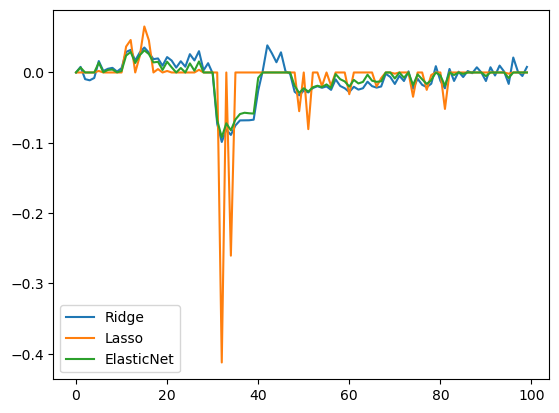

In [30]:
X = modeling_data['model_input']
y = modeling_data['model_output'].reshape(-1,1)

def evaluate_model(model, X, y, cv_splits):
	# average the loss over all cross-validation splits
	total_mape = 0
	for train_idxs, test_idxs in cv_splits:
		# standardize input and output data (using only the training data to create the scaler)
		scaler_X = StandardScaler().fit(X[train_idxs])
		scaler_y = StandardScaler().fit(y[train_idxs])
		X_sc = scaler_X.transform(X)
		y_sc = scaler_y.transform(y)

		# fit model to scaled input and output data
		model.fit(X_sc[train_idxs], y_sc[train_idxs])
		
		# get predictions
		y_pred_sc = model.predict(X_sc[test_idxs])

		# add loss to total
		total_mape += mean_absolute_percentage_error(y_sc[test_idxs], y_pred_sc)

	# return average cross-validation loss
	return total_mape / len(cv_splits)


model_ridge = Ridge(
	alpha=579.1840858977438,
	random_state=random_state
)
print("Ridge", evaluate_model(model_ridge, X, y, cv_splits))

model_lasso = Lasso(
	alpha=0.0199578037835924,
	random_state=random_state
)
print("Lasso", evaluate_model(model_lasso, X, y, cv_splits))

model_elasticnet = ElasticNet(
	alpha=0.27425943895110727,
    l1_ratio=0.036888918331993786,
	random_state=random_state
)
print("ElasticNet", evaluate_model(model_elasticnet, X, y, cv_splits))

model_rf = RandomForestRegressor(
	n_estimators=43,
    min_samples_split=0.010295479084487507,
    min_samples_leaf=0.010056298095605418,
    max_features=0.4243720636276546,
    max_samples=0.9999220363556389,
	random_state=random_state
)
print("RandomForest", evaluate_model(model_rf, X, y, cv_splits))


plt.plot(model_ridge.coef_[0, :], label='Ridge')
plt.plot(model_lasso.coef_, label='Lasso')
plt.plot(model_elasticnet.coef_, label='ElasticNet')
plt.legend()
plt.show()
